# Derek Herincx- Text Mining a Chevrolet Forum

Note: Each markdown box gives a brief explanation of the following cell. To see the progression of the dataframe, I have printed out the dataframe as visual confirmation of the written code. I printed specific row values when I wanted to emphasize a specific procedure such as tokenization, stop words removal, and other data cleaning procedures

In [2]:
#Initializing needed packages
from urllib.request import Request,urlopen
from bs4 import BeautifulSoup
import re
import time
import random
import nltk.corpus
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
from collections import Counter
from ast import literal_eval
import pandas as pd
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter

# Code setup and background

Basic setup and lists needed: Although the NLTK package provides a tokenizer, I realized that due to the uncleanliness of text data from this forum, the NTLK tokenizer made it more difficult to analyze data. In addition,  I manually added contractions that I knew are popular in the English language we commonly speak here in the U.S. (the NLTK package is based on British English). In addition, the models listed below are the entire list of Chevrolet models that Edmunds lists under Chevrolet. I will compare meta tags with this 'models' list to extract the model name from the data.

In [3]:
#Models for Chevrolet brand will be matched with text data

models = ['astro', 'astro cargo','avalanche', 'aveo', 'beretta','black diamond','avalanche','blazer','bolt','c/k','camaro',
          'captiva sport', 'cavalier','celebrity','chevy van','chevy van cls', 'city express','classic','cobalt','colorado',
          'corsica','corvette','corvette stingray','cruze','cruze limited','equinox', 'express','hhr','impala', 'impala limited',
          'lumina', 'lumina minivan','malibu','malibu classic','malibu hybrid','malibu limited','malibu maxx','metro',
          'monte carlo','prizm','r/v 3500 series','s-10','s-10 blazer','silverado', 'silverado 1500','silverado 1500 classic',
          'silverado hybrid','silverado 1500hd', 'silverado1500hd classic','silverado 2500', 'silverado 2500hd',
          'silverado 2500hd classic','silverado 3500', 'silverado 3500 classic', 'silverado 3500hd classic', 'sonic','spark',
          'spark ev', 'sportvan','ss', 'ssr','suburban','tahoe','tahoe hybrid','tahoe limited/z71','tracker','trail blazer',
          'trail blazer ext','traverse', 'trax','uplander', 'venture', 'volt']
          
#stopwords from NLTK is not an exhaustive set. Added other contractions from our colloquial English
contractions = ["ain't", "aren't", "can't", "could've", "couldn't", "gonna", "gotta", "hadn't", "hasn't",
                "haven't", "he'd", "he'll", "he's","how'd", "how'll","how're", "how's", "i'm","i'd", "i'll", "it'll", "it's",
                "let's", "might've", "mustn't", "must've", "she'll", "shouldn't", "somebody's","that's",
                "that'd", "there'll", "there's", "they'd", "they'll", "they're","they've", "wasn't",
                "we'd", "wed've", "we'll", "we're", "we've","weren't", "what'd","what'll", "what's", 
                "what've", "when's", "where'd", "who'd", "who'll", "who's", "who've", "why'd", "won't",
                "would've", "wouldn't", "y'all", "you'd", "you'll", "you're", "you've"]

# Data Acquisition using Beautiful Soup

DATA COLLECTION (code overview): Although a wide variety of car forums exist online, Edmunds.com seems to be highly popular among car enthusiasts. Focusing solely on the Chevrolet brand forum, an inspection of the webpage revealed that there are 92 pages of forum posts. Each page contains 40 posts, with the exception of the last page. I identified the basic hierarchy of the website and proceeded to use Beautiful Soup to scrape and obtain the forum text data. There are two loops below. The first loop will extract the href links that open the webpage containing the forum posts. The second loop iterates over each href link and extracts the text data from the div tag (under the attribute 'class'). Each post is appended to the list named 'posts.'

In [4]:
#Extracting all forum posts from Edmunds
links=list()
forum_links = list()
posts = list()
hdr = {'User-Agent': 'Chrome'}
tags_for_model = list()

#For Chevrolet, there are 92 pages of forum posts
for i in range(1,93):
    time.sleep(random.randint(10,30))
    html_page = 'https://forums.edmunds.com/discussions/tagged/chevrolet/chevrolet/p' + str(i)
    req = Request(html_page, headers=hdr)
    page = urlopen(req)
    soup = BeautifulSoup(page, 'lxml')
     
     
    '''Under the div tag, there are sub-links leading to the actual forum post. Loop thru all pages and extract all links
    Under the div tag, the link to the post is under the href tag. This extracts the link only and not the entire tag
    '''
    tags = soup.find_all('div', {'class':'Title'})
    for t in range(len(tags)):
        forum_links.append(tags[t].a['href'])

#Adding the text data to the 'posts' list
for f in forum_links:
    req = Request(f, headers=hdr)
    post_page = urlopen(req)
    soup_post = BeautifulSoup(post_page, 'lxml')
    post = soup_post.find('div', {'class': 'Message'})
    posts.append(post.get_text(" ").strip())

Due to the number of Chevrolet posts (which took an hour to retrieve), I decided to test my code by just extracting the actual post first. I noticed that under each post, a list of meta tags identified the model of the car. The following block of code extracts all these tags per post. The tags will be a list. Extraction of model will be done once data is organized in a dataframe. (Again, this loop could have been run above, but in doing so, I got no output when I ran my code for 10 hours)

In [39]:
for f in forum_links:
    req = Request(f, headers=hdr)
    post_page = urlopen(req)
    meta_soup = BeautifulSoup(post_page, 'lxml')
    meta = meta_soup.find('div', {'class': 'InlineTags Meta'})
    meta_tags = meta.find_all('li')
    tags_for_model.append([meta_tags[i].text for i in range(len(meta_tags))])


Moving onto a dataframe structure: Importing text data for analysis into dataframe 'df' by using a dictionary and rearranged columns to display text data on leftmost column. Exported 'df' as csv for later reference.

In [2]:
pre_df = {'Posts': posts, 'Model': tags_for_model}
df = DataFrame(pre_df)
df = df[['Posts', 'Model']]
posts_csv = df.to_csv("C://Users//Derek Herincx//Desktop//posts.csv")

Data import and saving: This block of code will allow me to read my posts dataframe from my desktop. Due to some import quirks with Python, I cleaned my dataframe by removing an 'Unnamed' column of indices it created. Because the meta tags column contains both the model name and post keywords, I created a third 'Keywords' column (an exact copy of the data from 'Model'). After further analysis, I realized that the meta tags also contain the vehicle year, so I made a third column called 'Vehicle Year' containing the same meta tags as both the 'Model' and 'Keywords' column. Analysis of these columns will be shown down below. Dimensions of dataframe are verified in cell below.

In [5]:
df=pd.read_csv("C://Users//Derek Herincx//Desktop//posts.csv", encoding='latin1')

'''When using read_csv, Python converts inputs into Python datatypes. Must hardcode these to prevent errors from occuring.
Used df.drop to drop an extra index column that appeared when exporting data to csv file. Making a copy of the 'Model' column
so I can extract meaningful tags from data.'''

df.Posts = df.Posts.astype(str)
df.Model = df.Model.apply(lambda x: literal_eval(x))
df = df.drop('Unnamed: 0', axis=1)
df['Keywords'] = df['Model']
df['Vehicle_Year'] = 0

df.shape #verifying dimensions of dataframe

(3677, 4)

# Data Analysis using lambdas, filter, NLTK, and own functions

DATA CLEANING: The following block of code removes punctuation marks from the data. Because all these operations will be used once, I used a lambda function to reduce code length. By using apply, each lambda function is applied to each row in 'df' (and only to the column 'Posts'). To remove entirety of punctuation, I used string.punctuation. Although the NLTK package does contain a tokenizing function, I realized that this tokenizer would split contractions at the apostrophe. Since stopwords in NLTK are saved in their contraction-format, I needed to preserve the entire contraction. Therefore, I used a list comprehension to split the text by white space, thus allowing me to preserve the contraction. What results is a list for each post; each word represents an item in a list. This allows us to reduce text even further. Again, the tokenization is applied via a lambda function across each row in 'df.'

In [6]:
#apostrophe & quote font is different in text data. Must be replaced with standardized font. Helps remove these symbols
df.Posts= df.Posts.apply(lambda x: x.lower())
df.Posts = df.Posts.apply(lambda x: x.replace("’", "'"))
df.Posts = df.Posts.apply(lambda x: x.replace("“", ' '))
df.Posts = df.Posts.apply(lambda x: x.replace("”", ' '))

#using string.punctuation to remove any remaing punctuation in text. Also a backup for lines of code above
punctuation = set(string.punctuation)

#tokenizing each post by whitespace, punctuation is removed from beginning and end of post ONLY
df.Posts = df.Posts.apply(lambda x: [word.strip(string.punctuation) for word in x.split(' ')])

#removing each punctuation mark within each (tokenized) post
df.Posts = df.Posts.apply(lambda x: [p for p in x if p not in punctuation])
df.Posts = df.Posts.apply(lambda x: [c for c in x if c not in contractions])

#removing model names from text (we will have a separate column for the model in dataframe)
df.Posts = df.Posts.apply(lambda x:[w for w in x if w not in models])

df.loc[12].Posts #Viewing an example of index 12 tokenized post

['ask',
 'your',
 '2018',
 'lease',
 'questions',
 'here',
 'get',
 'info',
 'about',
 'prices',
 'money',
 'factor',
 'deals',
 'incentives',
 'and',
 'payments',
 'get',
 '2018',
 'information',
 'here']

Using the NLTK package, I imported a list of stopwords from the English language. Because stop words bring no meaning, it is imperative they are removed before analysis. These words are stored as a set named 'stop_words.' Having each word as a token allows us to use our stop_words set. Via a lambda function and list comprehension, the logic is as follows. If a word in the tokenized post is not in stop_words, keep it. What results is a list of non stop words.

In [7]:
#list of stop_words from NLTK package to be removed from text data
stop_words = set(stopwords.words('english'))

#removing stop words. 
df.Posts = df.Posts.apply(lambda x: [w for w in x if w not in stop_words])

#rejoining the text together as one string. 
df.Posts = df.Posts.apply(lambda x: ' '.join(x))

df.Posts.head(10) #viewing posts with stop words removed

0    2001 chevy 1500 5.3l v8 wondering anyone infor...
1    ask 2018 lease questions  get info prices mone...
2    tell current lease incentives chevy 2018 lt cr...
3    ask 2018 lease questions get info prices deals...
4    fed hearing others problem gm taking responsib...
5    howdy  got 04 tb 4.2l v6 06 13k miles 23k mile...
6    hello  first time forum apologize dumb quest...
7    replaced ww motor ok.....wipers position half ...
8    ask 2018 lease questions get info prices money...
9    ask 2018 lease questions get info prices deals...
Name: Posts, dtype: object

WRITING FUNCTIONS (Problem encountered in text data): Punctuation isn't solely located at the beginning and end of text data. It can be anywhere in between text and the spacing between punctuation and words can cause problems. To address the existence of punctuation, I wrote a function called middle_text_clean that will rid text of any remaining punctuation. In addition, I also noticed that numbers were used in a variety of ways. Some people would refer to miles as "100k" or 100,000. Others would use '2006', '06', or " '06 " to refer to the car model year. Numbers were causing more problems in the text data so I allowed the following function to remove numbers entirely. Attributes of specific car models are more important than years because it sets a baseline for comparison, eh?

In [8]:
#Function will clean any punctuation in middle of text. Paramter 'x' is text data.
def middle_text_clean(x):
    '''
    Will renove any punctuation located in middle of text data.
    '''
    
    numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    s= []
    
    for i in x:
        i = list(i)
        for j in range(len(i)):
            if i[j] in punctuation:
                i[j]=''
            elif i[j] in numbers:
                i[j]= ''

        if '' in i:
            i[j]= ' '
        s.append(''.join(i))
    
    x=s
    x= [j for j in x if j!='']
    x = ''.join(x) 
    
    return x

df.Posts = df.Posts.apply(lambda x: middle_text_clean(x))
df.loc[300].Posts #Example of index 300 cleaned Post

'since bought used blaze   years ago little led indicator security always blinks issues    until go start dash indicators come security dash indicator never seen come engine even try turn   since clicking thought maybe starter suddenly died since everything tried waiting putting neutral back park etc work first happened town panicked called home hubby said jiggle wheel go neutral park wait try started right problems days yesterday go leave work no go  matter try start security indicator told mechanics deal dealer fuse wire something disconnect security feature least fool proof way get around use vehicle   boonies stranded home till fix'

# Further data extraction from meta tags

Model name extraction: Currently, I've only worked on the 'Posts' column. Now, in order to determine what words are associated with each Chevrolet model, each row must be associated with a model name. Currently, the 'Models' column has a list of meta tags that contain the car model being referenced in the post. Therefore, the code below defines a function 'model_extract' that will match list data from the Model column to the 'models' list. The result is a single item: the model type. If the result is an empty whitespace, then the post makes no explicit reference to a model.

In [9]:
def model_extract (x):
    '''
    Will match list data from one column with another list to extract car model name
    '''
    x = [i.lower() for i in x]
    m= []

    for j in range(len(x)):
        if 'chevrolet' in x[j]:
            x[j]=x[j].replace('chevrolet', '')
     
    for j in x:
        j= j.strip()
        if j in models:
            m.append(j)
        
    return ''.join(m)

#applying the 'model_extract' function to the 'Model' column
df.Model = df.Model.apply(lambda x: model_extract(x)) 
df.head(10) #displaying the first 10 rows of data

,Posts,Model,Keywords,Vehicle_Year
0,chevy l v wondering anyone infor...,silverado 1500,"[Chevrolet, Chevrolet Silverado 1500, Repairs ...",0
1,ask lease questions get info prices mone...,tahoe,"[Chevrolet, Chevrolet Tahoe, Buying & Selling,...",0
2,tell current lease incentives chevy lt cr...,colorado,"[Chevrolet, Chevrolet Colorado, 2018, Car Buyi...",0
3,ask lease questions get info prices deals...,colorado,"[Chevrolet, Chevrolet Colorado, Buying & Selli...",0
4,fed hearing others problem gm taking responsib...,colorado,"[Chevrolet, Chevrolet Colorado, Repairs & Main...",0
5,howdy got tb l v k miles k mile...,,"[Chevrolet, Chevrolet TrailBlazer, Repairs & M...",0
6,hello first time forum apologize dumb quest...,tahoe,"[Chevrolet, Chevrolet Tahoe, Buying & Selling,...",0
7,replaced ww motor ok wipers position half ...,blazer,"[Chevrolet, Chevrolet Blazer, Repairs & Mainte...",0
8,ask lease questions get info prices money...,malibu,"[Chevrolet, Chevrolet Malibu, Buying & Selling...",0
9,ask lease questions get info prices deals...,cruze,"[Chevrolet, Chevrolet Cruze, Buying & Selling,...",0


The next function called keywords_extract will work explicitly with the meta tags to determine the reasons why users are posting on the forum. This function will eliminate non-sensical words such as chevrolet (since we know this is a Chevrolet forum). Therefore, the keywords column will return a list of meaningful keywords.

In [10]:
def keywords_extract (x):
    '''
    From a list, will match list data from one column with another list to extract meaningful keywords
    '''
    x = [i.lower() for i in x]
    k = []
    
    for j in range(len(x)):
        if 'chevrolet' in x[j]:
            x[j]=x[j].replace('chevrolet', '')
        
    for j in x:
        j= j.strip()
        if j  not in models:
            k.append(j) 
        if '' in k:
            k.remove('')
   
    return k

df.Keywords = df.Keywords.apply(lambda x: keywords_extract(x))
df.head(10) 

,Posts,Model,Keywords,Vehicle_Year
0,chevy l v wondering anyone infor...,silverado 1500,"[repairs & maintenance, transmission & driveline]",0
1,ask lease questions get info prices mone...,tahoe,"[buying & selling, leasing, 2018]",0
2,tell current lease incentives chevy lt cr...,colorado,"[2018, car buying advice, leasing and incentives]",0
3,ask lease questions get info prices deals...,colorado,"[buying & selling, buying, leasing, 2018]",0
4,fed hearing others problem gm taking responsib...,colorado,"[repairs & maintenance, engine, 2012, 2012 che...",0
5,howdy got tb l v k miles k mile...,,"[trailblazer, repairs & maintenance]",0
6,hello first time forum apologize dumb quest...,tahoe,"[buying & selling, values & prices paid, 2018]",0
7,replaced ww motor ok wipers position half ...,blazer,"[repairs & maintenance, electrical, 2000]",0
8,ask lease questions get info prices money...,malibu,"[buying & selling, buying, leasing, 2018]",0
9,ask lease questions get info prices deals...,cruze,"[buying & selling, buying, leasing, 2018]",0


To avoide data repetition between two columns, I removed the year from the Keywords list using a regular expression named 'expression.'Line 3 containing both a lambda and filter function iterates through the meta tags list and returns matches to regex expression "\d{4}$". Since each post should only refer to one year, line 3 should return only one value (as a string). If the row value is empty, there is no match.

In [11]:
#extracting vehicle year from meta tags; if value = 0, means no match with re expression
expression = re.compile("\d{4}$")
df.Vehicle_Year= df.Keywords.apply(lambda x:''.join(list(filter(expression.match, x))))
df.Keywords = df.Keywords.apply(lambda x:[i for i in x if not expression.search(i)])

Final Cleaning: These steps are copies of the first data cleaning steps made when the dataframe was initially created. After cleaning punctuation, removing stop words, and adding whitespace as a conservative way to keep words spaced out, some tokens ended up having one character (e.g. 'h' or 'v'). For this reason, I made one final cleaning iteration, presented below, which removed tokens of length 1.

In [12]:
df.Posts = df.Posts.apply(lambda x: x.split(' '))
df.Posts = df.Posts.apply(lambda x: [x[i] for i in range(len(x)) if len(x[i])!=1])
df.Posts = df.Posts.apply(lambda x: ' '.join(x))

# Data Visualization- Which car model is mentioned most frequently? What words appear most frequently with this model?

Summary statistics and initial observations: About 20.3% of our data is unusable (i.e. model is labeled as '0'). There were two instances in which the model was '0'. The first case was when none of the meta_tags for the post matched with a value in the models list. The second instance was when a user referred to multiple models in the tag. For example, one user's model was "silverado1500silverado2500silverado3500," indicating that multiple tags matched with values in the models list. Because Edmunds allows a user to narrow down user searches by a specific model (Silverado 1500 != Silverado 1500 hd), I excluded these vague instances from my analysis. Note: the models_freq data frame excludes the frequency of zeroes from our dataset.

In [13]:
#replacing white space in Model with 0
for i in range(len(df)):
    df.loc[i].replace('',0, inplace=True)

#Extracts value counts per value in Model
models_freq= pd.DataFrame(df.Model.value_counts())

#Since the model is used as an index, I reset indices to numerical values here
models_freq = models_freq.reset_index()
#renaming columns with logical names
models_freq.columns = ['Car_Model', 'Frequency']

#Excludes row with Model == '0'. Comment this line to view full dataframe of model frequencies.
models_freq = models_freq[models_freq.Car_Model !=0]
models_freq

,Car_Model,Frequency
1,silverado 1500,291
2,suburban,207
3,equinox,201
4,impala,197
5,tahoe,190
6,colorado,173
7,blazer,155
8,malibu,143
9,s-10,114
10,volt,110


Visualizing the 'models_freq' dataframe through a bar chart. First 12 models were mentioned more than 100 times in the dataset. We can observe that the largest drop in posts comes after the Chevy Malibu (Malibu = 143, S-10=114).In contrast, the Silverado 1500 model was mentioned nearly 300 times. It would be interesting to note reasons users are posting so much about it. If we make the assumption that the car model with the highest frequency in df is the car model with the most problems, then we have to assume that EVERY post on Edmunds.com is posted because of some problem with that vehicle model. Although I believe that most people don't post on forums unless they face some issue, it is unlikely to assume that every post is directly linked to a problem.Let's take a look at the most frequently mentioned models below.

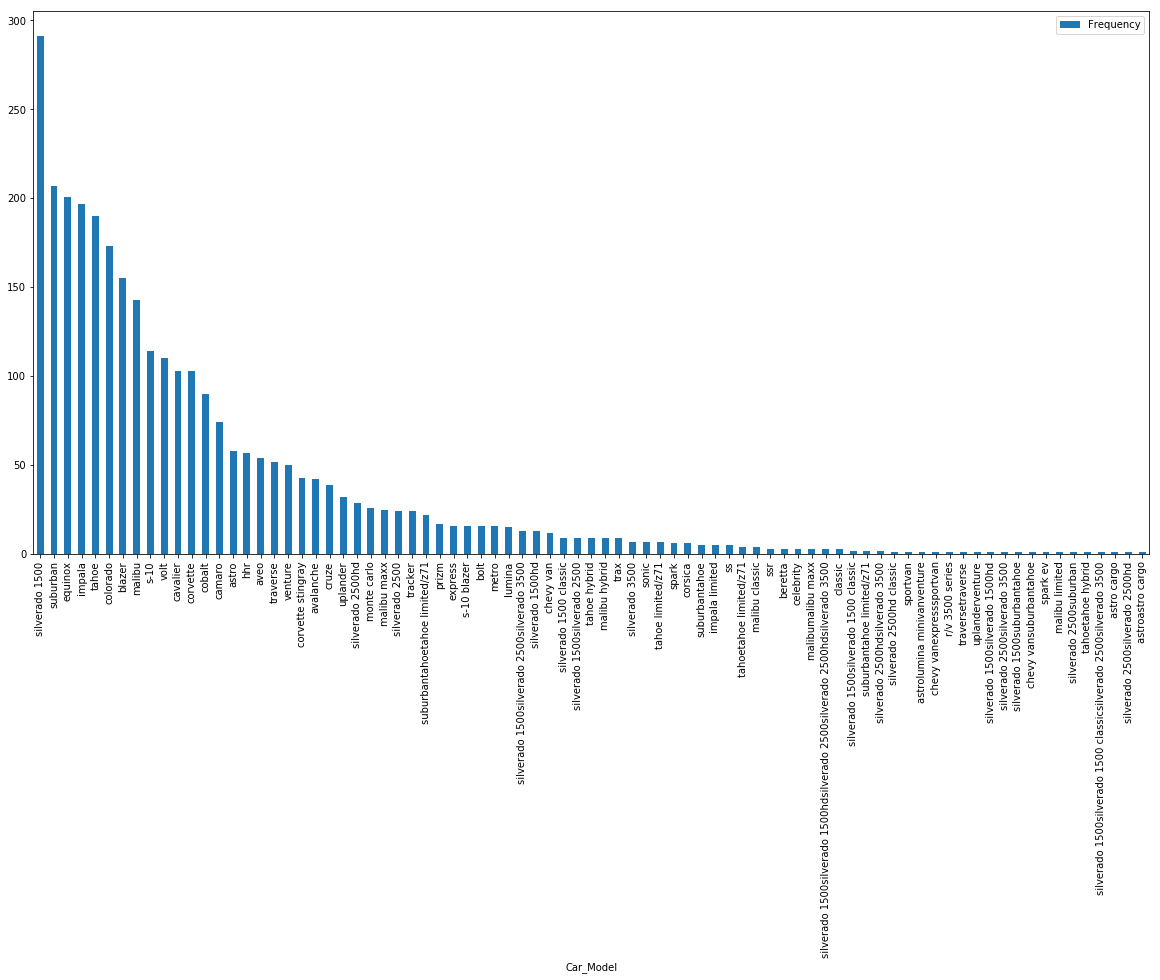

In [16]:
#Bar graph plotting frequency of each model in our dataset
freq_plot =models_freq.plot.bar(x='Car_Model', y='Frequency', figsize=(20,10))
plt.show()

Using the wordcloud function from WordCloud, I defined a function named cloud to facilitate the creation of the wordcloud. In this simple function, I specify the model of interest (e.g. if I specify 'camaro', my wordcloud will filter posts in which the model name is 'camaro'), the color of the cloud, the width, the height, and the number of words desired.

In [14]:
def cloud(model, color, w, h, num):
    '''
    Function creating a wordcloud with specific color, width, height, number of words, and text data
    '''
    
    data = ''.join(df.Posts[df.Model == model])
    wordcloud = WordCloud(background_color = color, width =w, height=h, max_words=num).generate(data)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
    return wordcloud

First iteration of wordclouds for top 10 mentioned models (based on models_freq dataframe). Used a loop to iterate through the top_ten models list. The first major observation that I make is that the most significant words are clearly obvious based on the context of our analysis. For example, in each word cloud, 'problem' appears. In a few other word clouds, 'chevy', 'gm', and 'truck' are mentioned. These words are implied because we know the model name. Therefore, I will run a second iteration removing these words and the result will be presented in a cell below. What is interesting is that the word 'mile' appears in each word cloud. Yet, because it doesn't make much sense in this context, I chose to remove it below.

Word Cloud for silverado 1500


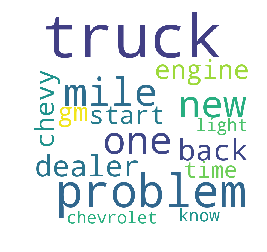

Word Cloud for suburban


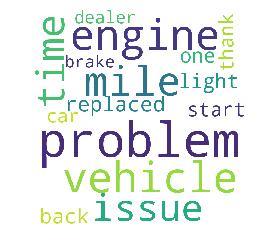

Word Cloud for equinox


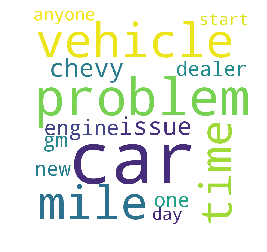

Word Cloud for impala


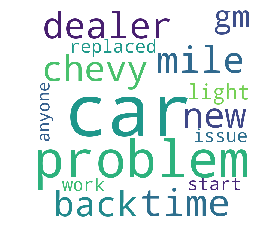

Word Cloud for tahoe


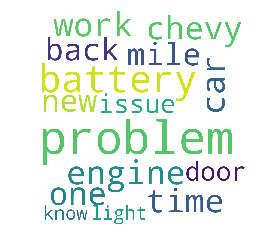

Word Cloud for colorado


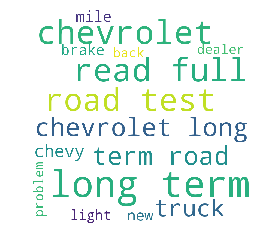

Word Cloud for blazer


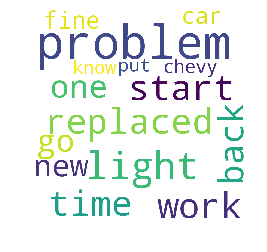

Word Cloud for malibu


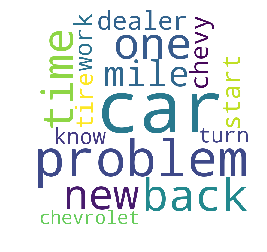

Word Cloud for s-10


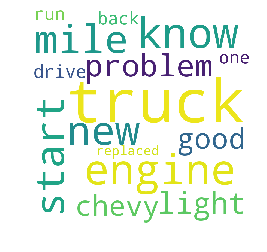

Word Cloud for volt


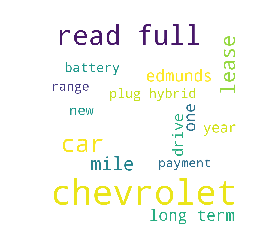

In [15]:
top_ten= list(models_freq.iloc[list(range(0,10))].Car_Model)
for model in top_ten:
    print("Word Cloud for "+ model)
    cloud(model, 'white', 800,800, 15)

Removing words that bring no contextual meaning within the top 10 model word clouds. Code should look similar to some of the pre-processing done above.

In [16]:
clean_up_words = ['problem', 'chevrolet', 'gm', 'truck', 'chevy', 'car', 'anyone', 'vehicle', 'edmunds', 'mile', 'miles',
                 'issue']
df.Posts = df.Posts.apply(lambda x: x.split(' '))
df.Posts = df.Posts.apply(lambda x:[i for i in x if i not in clean_up_words])
df.Posts = df.Posts.apply(lambda x: ' '.join(x))

Word Cloud for silverado 1500


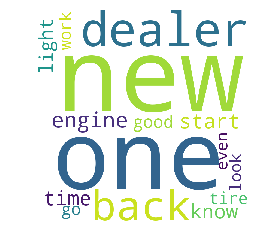

Word Cloud for suburban


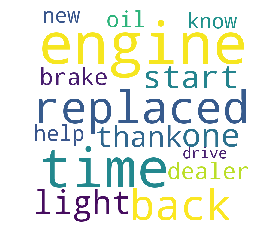

Word Cloud for equinox


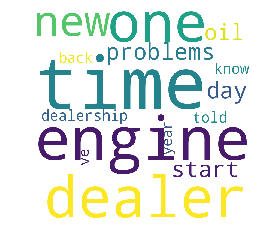

Word Cloud for impala


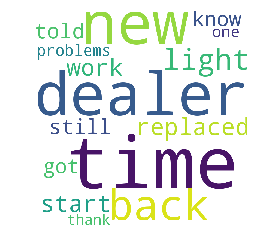

Word Cloud for tahoe


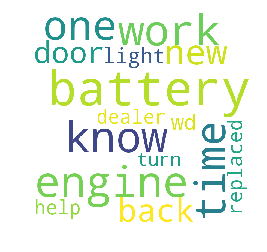

Word Cloud for colorado


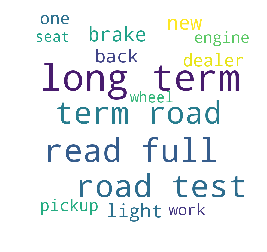

Word Cloud for blazer


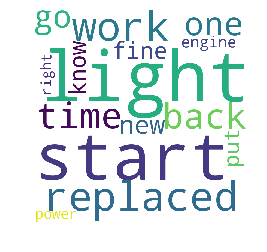

Word Cloud for malibu


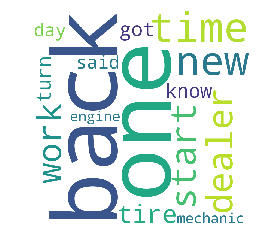

Word Cloud for s-10


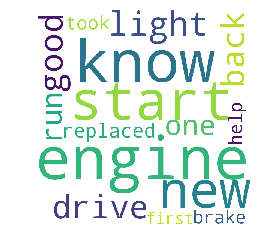

Word Cloud for volt


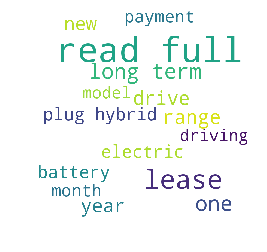

In [17]:
top_ten= list(models_freq.iloc[list(range(0,10))].Car_Model)
for model in top_ten:
    print("Word Cloud for "+ model)
    cloud(model, 'white', 800,800, 15)

#  Data Analysis Part II (An exemplar): Scikt Learn and Inverse-Term Matrix for the Silverado 1500

In the visualization analysis above, a frequently occuring word was given a high level of importance; posts for each vehicle model were aggregated into one corpus and wordclouds were based on this per-model corpus. A higher frequency word is given a higher score. But there are other factors to consider: in a longer post, a single word has more opportunity to occur, hinting at the need for som type of normalization. Second, in text mining, the goal is to identify unique keywords that will indicate attributes of a specific vehicle model. This information will be providede by the inverse term matrix.

In [18]:
#Extracting list of posts for Chevy Silverado 1500; length is 291
silverado_corpus = (df[(df['Model']=='silverado 1500')].Posts).tolist()
tfidf_vectorizer = TfidfVectorizer(min_df=1)
#Creating the TF-IDF matrix. Too large to view but this the creation and example view of matrix created
tfidf_matrix = tfidf_vectorizer.fit_transform(silverado_corpus)
print(tfidf_matrix.todense())

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


Rather than look at the entire TF-IDF matrix, we will extract terms and non-zero scores. The dictionary comprehension below provides the token and its index (e.g. column number) within the matrix. By specifying the .items() method, the loop will iterate over dictionary items, represented as tuples . What I am interested in is not the index of the term, but its TF-IDF weight. For this, I created a list named fully_indexed. The loop in line 4-5 will iterate through each row in each matrix; within each row, the loop will retrieve the non-zero indices and the weights of those indices (via row.data) and store them in a dictionary (each dictionary representing the non-zero weights of each row). The last loop appends the top 3 weighted words per Posts into list 't', which will be appended to our original df dataframe

In [19]:
index_value = {i[1]:i[0] for i in tfidf_vectorizer.vocabulary_.items()}

fully_indexed = []
for row in tfidf_matrix:
    fully_indexed.append({index_value[column]:value for (column,value) in zip(row.indices,row.data)})

t = list()
for i in range(len(fully_indexed)):
    d = Counter(fully_indexed[i]).most_common(3)
    t.append(d)

Because the 'Silverado 1500' model was mentioned most frequently in forum posts, tfidf only considers the 291 Silverado 1500 posts from df. The following lines clean up the dataframe 'df' and append the list from our inverse matrix into a column named 'tf_idf.' Per post, the top 3 weighted terms will appear.

In [20]:
df_silverado = df[(df['Model']=='silverado 1500')]
df_silverado= df_silverado.reset_index()
df_silverado.drop(['index'], axis=1)
df_silverado['tf_idf']= t
df_silverado #viewing a subset of df with model='silverado 1500' and results of tf-idf

,index,Posts,Model,Keywords,Vehicle_Year,tf_idf
0,0,wondering information takes conv...,silverado 1500,"[repairs & maintenance, transmission & driveline]",0,"[(manual, 0.452291607226), (transmission, 0.36..."
1,12,ask lease questions get info prices money...,silverado 1500,"[buying & selling, buying, leasing]",2018,"[(payments, 0.358525137544), (deals, 0.3342305..."
2,35,awd speaker loud static noise coming ev...,silverado 1500,"[features & accessories, repairs & maintenance...",2004,"[(static, 0.3890857486), (awd, 0.362720262849)..."
3,49,motor swap pickup took put exact motor ...,silverado 1500,"[repairs & maintenance, transmission & driveline]",1995,"[(motor, 0.549506021379), (swap, 0.42157085908..."
4,52,active fuel management systems sierr...,silverado 1500,"[repairs & maintenance, fuel system]",0,"[(active, 0.569586372004), (management, 0.5695..."
5,72,could post rv mf lt crew cab souther...,silverado 1500,[],0,"[(southern, 0.428928762623), (california, 0.42..."
6,73,got months ago time dri...,silverado 1500,"[repairs & maintenance, no start]",2011,"[(lights, 0.297878332585), (wont, 0.2484754848..."
7,77,driving intermittently shut traction light com...,silverado 1500,"[repairs & maintenance, electrical]",2012,"[(several, 0.416882617587), (intermittently, 0..."
8,88,hello silvrado start crank battery...,silverado 1500,"[repairs & maintenance, engine]",2003,"[(crank, 0.359174758715), (times, 0.2912372614..."
9,115,hear grinding noise going road gets ...,silverado 1500,"[repairs & maintenance, transmission & driveline]",2006,"[(grinding, 0.301920442815), (curve, 0.3019204..."


# Does the TF-IDF matrix validate results of the wordcloud for the Chevrolet Silverado 1500?

The final cell below extracts the words with the highest weights for each document (e.g. post). Therefore, the list below is the same length as df_silverado: 291 items. To reiterate, the wordcloud places emphasis on frequently mentioned words. The fact that some words will naturally appear more frequently than others is ignored when focusing on term frequency. In the TF-IDF, this is considered and frequent words are penalized. Two attributes that seemed important in the silverado 1500 wordcloud were 'engine [start]','tire', 'light'. Why do I focus on these words? Because they are car attributes. So now the question is: what does the matrix tell us about these attributes?

To answer this question, lets look at the first few rows of the term:weight list below. In index 6, we see that one post makes reference to car lights not starting. If we scroll down a few posts, we also see that another user mentions an issue with the left tail blinker. What about the engine? If we do a brief overview, one user experiences problem with the crankshaft. Another user's transmission is shifting back...an indication of a serious problem for this vehicle model. Although a more in depth analysis can be performed, we can see that the results of the matrix are validated within our matrix. It provides us with more context about the issues addressed by the wordcloud.

In [21]:
for i in range(len(df_silverado)):
    print(df_silverado.loc[i].tf_idf)

[('manual', 0.45229160722641903), ('transmission', 0.36039123409936819), ('convert', 0.26703832115266718)]
[('payments', 0.35852513754420745), ('deals', 0.33423052012626742), ('get', 0.313527691829671)]
[('static', 0.38908574859960882), ('awd', 0.3627202628494367), ('speaker', 0.34401365300772374)]
[('motor', 0.54950602137904292), ('swap', 0.4215708590857592), ('shift', 0.37697781171392641)]
[('active', 0.56958637200398143), ('management', 0.56958637200398143), ('fuel', 0.36613849134153081)]
[('southern', 0.42892876262294199), ('california', 0.42892876262294199), ('rv', 0.4068075749362019)]
[('lights', 0.29787833258542684), ('wont', 0.24847548481986143), ('start', 0.24264507980646069)]
[('several', 0.41688261758680717), ('intermittently', 0.2784289895000468), ('disengage', 0.25956190022340375)]
[('crank', 0.35917475871513382), ('times', 0.29123726142845446), ('start', 0.25499647816496218)]
[('grinding', 0.30192044281494479), ('curve', 0.30192044281494479), ('rotating', 0.30192044281494

A cleaner version of above cell's output

In [84]:
clean_words = [[] for i in range(len(df_silverado))]
for i in range(len(df_silverado)):
    for j in range(len(df_silverado['tf_idf'].loc[i])):
        clean_words[i].append((df_silverado['tf_idf'].loc[i])[j][0])

clean_words

[['manual', 'transmission', 'convert'],
 ['payments', 'deals', 'get'],
 ['static', 'awd', 'speaker'],
 ['motor', 'swap', 'shift'],
 ['active', 'management', 'fuel'],
 ['southern', 'california', 'rv'],
 ['lights', 'wont', 'start'],
 ['several', 'intermittently', 'disengage'],
 ['crank', 'times', 'start'],
 ['grinding', 'curve', 'rotating'],
 ['start', 'guages', 'dome'],
 ['paint', 'chip', 'call'],
 ['ask', 'questions', 'lease'],
 ['house', 'vacuum', 'rpms'],
 ['fine', 'maintain', 'cut'],
 ['tick', 'hear', 'corner'],
 ['loading', 'snap', 'night'],
 ['cold', 'hot', 'air'],
 ['brake', 'pedal', 'time'],
 ['rust', 'undercarriage', 'areas'],
 ['item', 'sales', 'code'],
 ['approved', 'state', 'dealers'],
 ['overheating', 'coolant', 'radiator'],
 ['hump', 'sound', 'go'],
 ['gages', 'little', 'distance'],
 ['mint', 'milage', 'thx'],
 ['gills', 'apologize', 'user'],
 ['massachusetts', 'star', 'edition'],
 ['pulse', 'module', 'older'],
 ['mos', 'zip', 'ny'],
 ['stall', 'fine', 'start'],
 ['motor',

# Appendix: Unused Functions (might be useful later)

In [ ]:
def word_frequency(text):
    p = word_tokenize(text)

    freq= {}
    for word in p:
        if word not in freq:
            freq[word] = 1
        else:
            freq[word] +=1

    #creating a new dictionary called freq_sorted that sorts word frequency in descending order
    freq_sorted = sorted(freq, key=freq.get, reverse=True)
    for f in freq_sorted:
        print(f, freq[f])

In [ ]:
#to sort a dictionary named "inverse_dict" by its values; note you need to import itemgetter
sorted(inverse_dict.values())
sorted(inverse_dict.items(), key = itemgetter(1), reverse=True)